In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree

In [2]:
df = pd.read_parquet("target2_data.parquet")
target_col = "target"

In [3]:
# Veriyi Ayırıyoruz
X = df.drop(columns=[target_col])
y = df[target_col]

In [4]:
# Stratify ile bölmek zorundayız çünkü verimiz dengesiz
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
print(f"Veri Hazır: {X_train.shape[0]} eğitim örneği.")

Veri Hazır: 49145 eğitim örneği.


In [6]:
# Grid Search ile en iyi hiperparametreleri bulma

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_leaf": [1, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)

print("\nEn iyi parametreler aranıyor (GridSearch)...")
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

print(f"EN İYİ PARAMETRELER BULUNDU:\n {grid_search.best_params_}")


En iyi parametreler aranıyor (GridSearch)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
EN İYİ PARAMETRELER BULUNDU:
 {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 4, 'n_estimators': 200}



Confusion Matrix:


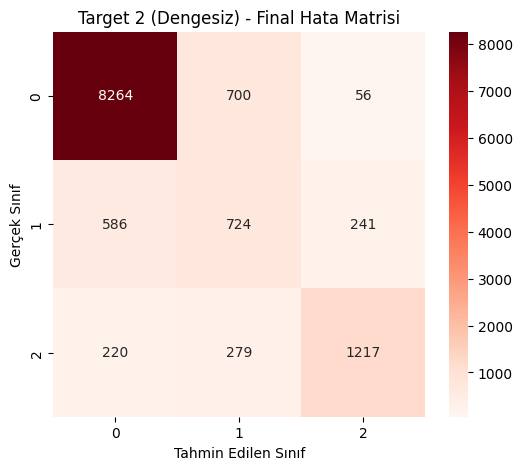


Classification Report:
              precision    recall  f1-score   support

           0      0.911     0.916     0.914      9020
           1      0.425     0.467     0.445      1551
           2      0.804     0.709     0.754      1716

    accuracy                          0.831     12287
   macro avg      0.713     0.697     0.704     12287
weighted avg      0.835     0.831     0.832     12287



In [13]:
y_pred = best_rf.predict(X_test)

# Sonuçları Değerlendirme

print("\nConfusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title('Target 2 (Dengesiz) - Final Hata Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

In [18]:
from imblearn.over_sampling import SMOTE

# SMOTE sadece X_train ve y_train'e uygulanır
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("SMOTE sonrası sınıf dağılımı:")
print(y_train_balanced.value_counts())

SMOTE sonrası sınıf dağılımı:
target
0    36079
2    36079
1    36079
Name: count, dtype: int64


Yeni Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      9020
           1       0.41      0.45      0.43      1551
           2       0.81      0.72      0.76      1716

    accuracy                           0.83     12287
   macro avg       0.71      0.69      0.70     12287
weighted avg       0.83      0.83      0.83     12287



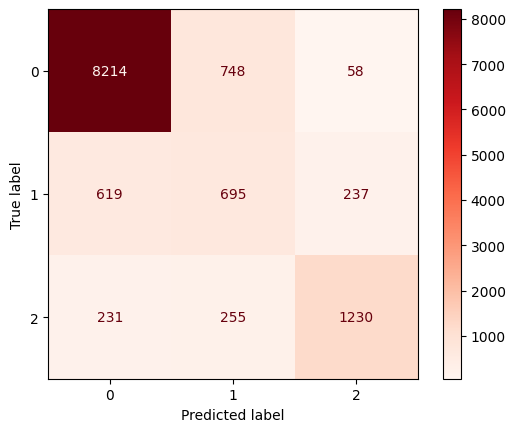

In [21]:
# En iyi parametrelerle model
best_rf.fit(X_train_balanced, y_train_balanced)

# Test verisinde tahmin
y_pred = best_rf.predict(X_test)

# Sonuçları değerlendirme
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Yeni Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Hata matrisi
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Reds")



Modelin Karar Mantığı (Örnek Bir Ağaç):


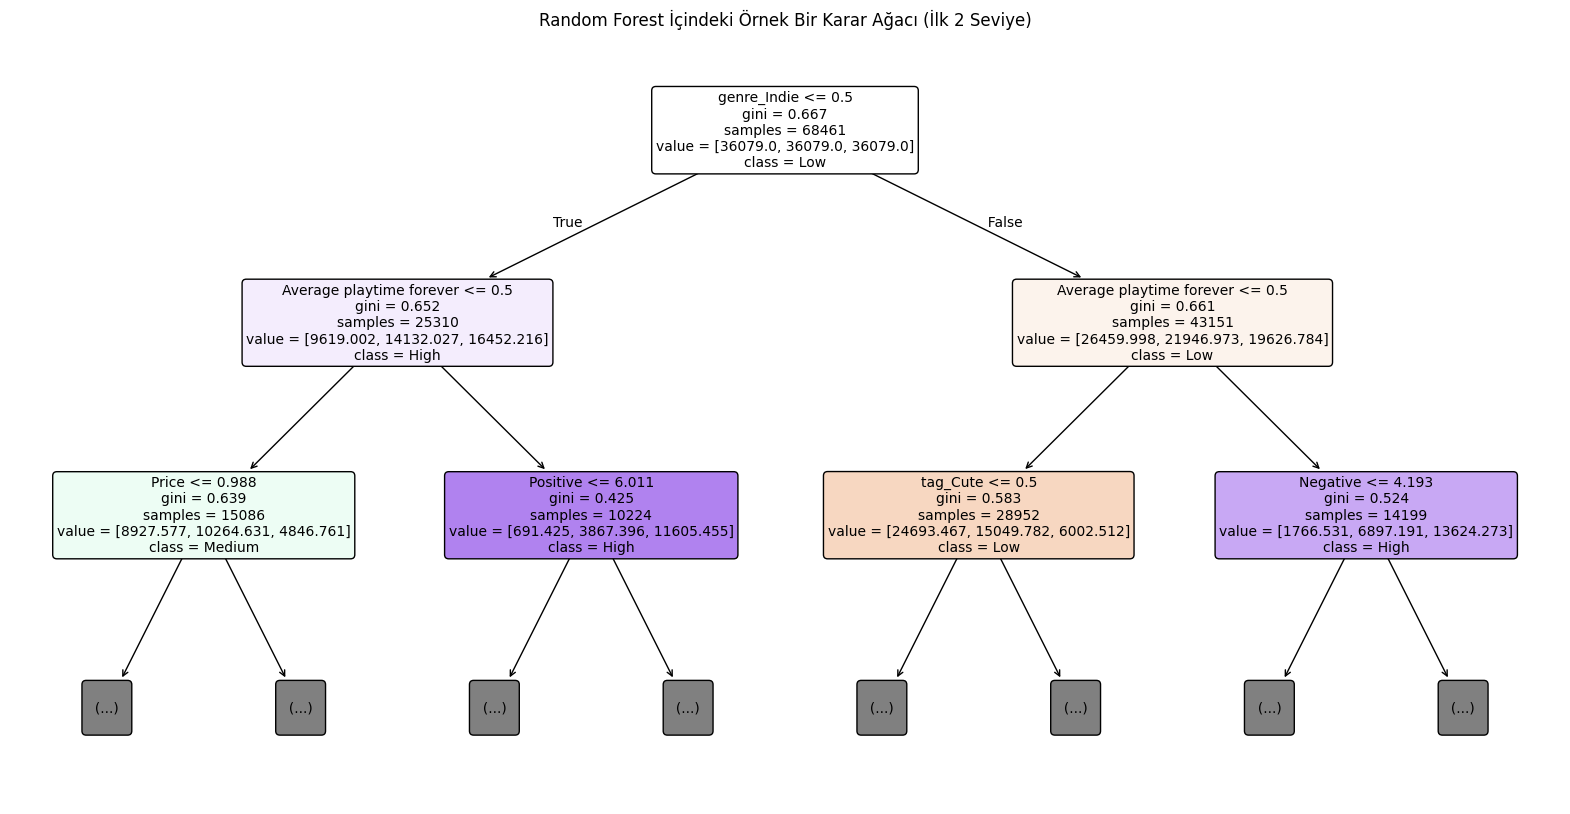

In [22]:
print("\nModelin Karar Mantığı (Örnek Bir Ağaç):")
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], 
          max_depth=2,               
          feature_names=X.columns,
          class_names=['Low', 'Medium', 'High'],
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Random Forest İçindeki Örnek Bir Karar Ağacı (İlk 2 Seviye)")
plt.show()

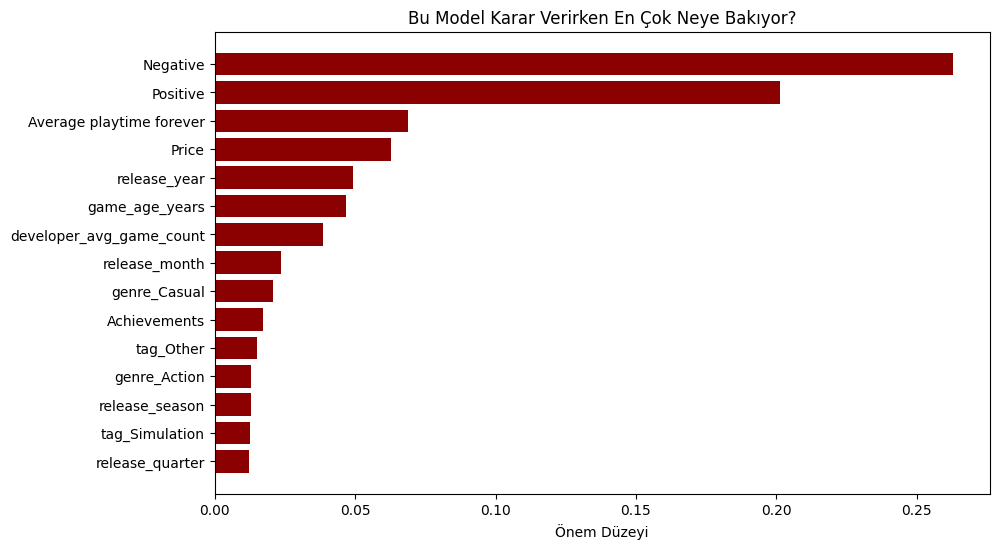

In [23]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-15:] # En önemli 10 özellik

plt.figure(figsize=(10, 6))
plt.title('Bu Model Karar Verirken En Çok Neye Bakıyor?')
plt.barh(range(len(indices)), importances[indices], color='darkred', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Önem Düzeyi')
plt.show()